# INF-285 / ILI-285
## Desafío 5 v1.1
### SCT 2020-1

## Instrucciones
* El desafío es individual, por lo cual se considera que todo el código entregado es de elaboración propia y no ha sido compartido de forma alguna.
* Las consultas sobre el desafío se deben realizar por medio de la plataforma Aula. **No está permitido publicar código en consultas de Aula**.
* El desafío debe ser realizado en Jupyter Notebook (Python3) utilizando este archivo como base.
* Debe utilizar arreglos de NumPy junto a las funciones y bibliotecas que se ponen a disposición en este archivo.
* Se debe respetar las firmas de las funciones, sus parámetros y retornos. Para eso se incluye un detalle de cada función tanto de las entregadas como las que deberá implementar. En caso de no seguir estas instrucciones, el desafío no podrá evaluarse.
* Se evaluará la correcta utilización de librerias NumPy, SciPy, entre otras, así como la correcta implementación de algoritmos de forma vectorizada.
* Evitar la impresión de mensajes salvo que se solicite en el enunciado.
* El archivo de entrega debe denominarse **ROL-desafio-numero.ipynb**. **De no respetarse este formato existirá un descuento de 50 puntos**.
* La fecha de entrega es el **4 de agosto a las 12:00 hrs**.

In [3]:
import numpy as np
import scipy.linalg as spla
import matplotlib.pyplot as plt

## Introducción

El objetivo de este desafío es evaluar su capacidad de "analista de datos" con un problema de regresión. 
Suponga que tiene el conjunto de datos $\{(x_1,y_1), (x_2, y_2), \dots, (x_m, y_m)\}$ para los cuales necesitamos ajustar un modelo del tipo $f(x, \boldsymbol{\beta})$ con $\boldsymbol{\beta}=\beta_1, \beta_2, \dots, \beta_n$, los parámetros del modelo. Considere por ejemplo que un modelo lineal sería:

\begin{equation}
    f(x, \boldsymbol{\beta})=\beta_1 + \beta_2\,x.
\end{equation}

Los datos provienen de algun instrumento de medición desconocido y se encuentran en la siguiente dirección: **[datos](https://github.com/sct-utfsm/INF-285/tree/master/desafios/data)**

## Tarea

La tarea es utilizar su creatividad para construir un modelo que se ajuste a los datos entregados. Para explorar visualmente los datos y posteriormente analizar su ajuste se pone a disposición la función ```plot(x_i, y_i, y_fit)``` que recibe los datos $x_i$, $y_i$, y en el caso que tenga su ajuste $y_{fit}$. 

In [4]:
def plot(x_i, y_i, y_fit=None):
    """
    Plot data

    Parameters
    -----------
    x_i     : (m, ) array
             Data x_i to fit
    y_i     : (m, ) array
             Data y_i to fit
    y_fit   : (m, ) array or None
             Model output

    Returns
    -------
    None
    """
    plt.figure(figsize=(12, 6))
    plt.plot(x_i, y_i, 'r.', label='Data')
    if y_fit is not None:
        plt.plot(x_i, y_fit, 'b-', label='Model')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.grid(True)
    plt.legend()
    plt.show()

### Evaluación

Para evaluar su modelo, utilizaremos el *error cuadrático relativo* definido como:
\begin{equation}
    SE_{rel} = \frac{\displaystyle \sum_{i=1}^m (y_i - f(x_i, \boldsymbol{\beta}))^2}{\displaystyle \sum_{i=1}^{m}y_i^2} = \frac{\displaystyle\sum_{i=1}^m (y_i - \hat{y}_i)^2}{\displaystyle \sum_{i=1}^{m}y_i^2}.
\end{equation}

Implemente la función ```SErel(y_i, y_fit)``` que reciba los valores de $y_i$ y los datos ajustados por su modelo $\hat{y}_i$ y retorne el valor del error relativo indicado.

In [5]:
def SErel(y_i, y_fit):
    """
    Relative SE computation

    Parameters
    -----------
    y_i     : (m, ) array
             Data y_i to fit
    y_fit   : (n, ) array 
             Model output

    Returns
    -------
    SE_rel  : float
             Relative SE value
    """
    
    n = y_i.shape[0]
    
    SE_num = np.sum([ (y_i[i] - y_fit[i])**2 for i in range(n) ])
    SE_den = np.sum([ y_i[i]**2 for i in range(n) ])
    
    SE_rel = SE_num/SE_den
    return SE_rel


Su nota se calculará utilizando el valor obtenido por el $SE_{rel}$ asociado a su modelo de la siguiente manera:

\begin{equation}
    nota(SE_{rel}) = 
    \begin{cases}
        100 & \text{si} \quad 0.08 \leq SE_{rel} \leq 0.15 \\
        round\left(\frac{835 - 900\,SE_{rel} }{7}\right) & \text{si} \quad SE_{rel} > 0.15\\
        0 & \text{si} \quad SE_{rel} < 0.08
    \end{cases}
\end{equation}

Se considera un ajuste deficiente si utiliza simplemente una función lineal para el ajuste, así que entre mejor sea su modelo, mejor será su nota ;). En el caso que el *error relativo* sea muy pequeño se puede considerar casi una interpolación, por lo tanto se evalúa con nota mínima. Puede utilizar la función adjunta para analizar la capacidad de su modelo.

In [6]:
def nota(se_rel):
    if se_rel < 0.08: # Are you sure it's not an interpolation?
        return 0
    elif 0.08 <= se_rel <= 0.15:
        return 100
    else:
        return np.round((835 - 900 * se_rel) / 7)

### Ajuste

Como hemos revisado en clases, podemos ajustar los parámetros de un modelo utilizando mínimos cuadrados. Para esto tenemos dos opciones: 

####  Resolver las ecuaciones normales: 

\begin{equation}
    A^*\, A \mathbf{x} = A^*\, \mathbf{b}
\end{equation}

#### Utilizar $QR$:

1. Aplicar $QR$ reducido para obtener $A = \hat{Q}\,\hat{R}$
2. Resolver $\hat{R}\,\mathbf{x}=\hat{Q}^*\,\mathbf{b}$

Para ambos casos recuerde que $A$ dependerá del modelo que usted proponga, $\mathbf{x}=\boldsymbol{\beta}$ y $\mathbf{b}$ es el vector asociado a $y_i$. Implemente la función ```modelFit(A, b, method)``` que reciba $A$, $\mathbf{b}$ y ```method``` para indicar si se utilizarán las *ecuaciones normales* o $QR$, y retorne los parámetros $\boldsymbol{\beta}$ del modelo que está ajustando.

In [7]:
def modelFit(A, b, method):
    """
    Curve fitting

    Parameters
    -----------
    A        : (m, n) array
              A matrix of overdetermined system of equations
    b        : (m, ) array
              b vector of overdetermined system of equations
    method   : string {'NE', 'QR'}
              Solving method with Normal Equations 'NE' or QR factorization'QR'

    Returns
    -------
    beta     : (n, ) array
              Model parameters 
    """
    
    
    m, n = A.shape
    
    Aa = A.conj().T
    
    if method == "NE":
        beta = spla.solve(np.dot(Aa,A), np.dot(Aa, b))
        
    elif method == "QR":
        
        Q = np.zeros_like(A)
        R = np.zeros([n,n])
        
        for i in range(n):
            y_i = A[:,i]
            for j in range(i):
                R[j][i] = np.dot(Q[:,j], y_i)
                y_i  -= np.dot(R[j][i],Q[:,j])
            R[i][i] = spla.norm(y_i)
            Q[:,i] = y_i/R[i][i]
                
        beta = spla.solve(R, np.dot(Q.T, b))
        
    return beta

----

## Desarrollo

### Cargar datos

In [8]:
# Load data
data = np.load("data/d_5.npy")
x_i = data[:,0]
y_i = data[:,1]

### Modelo

Como ejemplo se incluye un modelo lineal... Confiamos en que usted será más creativo en la construcción de su propuesta. Puede hacer uso de combinaciones de modelos vistos en clases, por ejemplo:
\begin{equation}
    f(x, \beta_1, \beta_2, \dots) = \beta_1 + \beta_2\,x^2 + \beta_2\,x\,\cos(2\pi x) + \dots
\end{equation}

In [9]:
# Modify this function. It is only an example
def model(b1, b2, x):
    return -4.3*b1+ \
            1.5*b2*x -\
            (x - 2) * np.tanh(1/((x-1)) - 0.2)**2 - \
            0.1*np.sin(1.2*x**2 - 0.6) + 0.12 - \
            (- 0.3 + 0.4*np.sin(0.57*x - np.pi)) + \
            0.25*np.cos(10*x + 4.5)\
            -((0.001*x-0.23) * (np.tanh(1/(10*(x-2.5)**2) - 0.5)))\
            -((0.001*x-0.2) * (np.tanh(1/(10*(x+1.5)**2) - 0.5)))\
            -((0.001*x-0.2) * (np.tanh(1/(10*(x+3.5)**2) - 0.1)))\
            -((0.001*x+0.2) * (np.tanh(1/(10*(x-1.3)**2) - 0.2)))\
            -((0.001*x+0.3) * (np.tanh(1/(10*(x+4.9)**2) - 0.2)))\
            -((0.001*x+0.2) * (np.tanh(1/(30*(x-0.7)**2) - 0.2)))\
            -((0.001*x+0.2) * (np.tanh(1/(15*(x-3.27)**2) - 5)))\
            -((0.001*x+0.3) * (np.tanh(1/(15*(x-3.9)**2) - 5)))\
            -((0.001*x-0.2) * (np.tanh(1/(15*(x-4.3)**2) - 1)))\
            -((0.001*x+0.18) * (np.tanh(1/(15*(x-4.5)**2) - 1.2)))\
            -((0.001*x-0.2) * (np.tanh(1/(15*(x-4.8)**2) - 0.5)))

Construcción de $A$ y $\mathbf{b}$

In [10]:
A = np.vstack((np.ones_like(x_i),x_i)).T
b = y_i

Obtención de parámetros...

In [11]:
beta = modelFit(A, b, "QR")

In [12]:
y_fit = model(beta[0], beta[1], x_i)

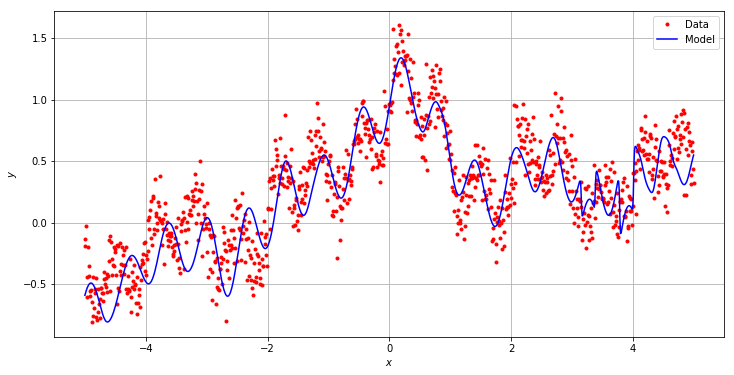

In [13]:
plot(x_i, y_i, y_fit)

Evaluación de su propuesta

In [14]:
se = SErel(y_i, y_fit)

In [15]:
print(se, nota(se))

0.2234800585122949 91.0
